In [1]:
import copy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from icedef import constants, iceberg, metocean, drift, tools, simulator, test_case, plot

# Testing with a Clinical Setup

In [2]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats

In [37]:
def run_test_simulation(start_location, time_frame, **kwargs):
    
    # Kwargs for testing
    constant_current_velocity = kwargs.pop('constant_current_velocity', None)
    constant_eastward_current_velocity = kwargs.pop('constant_eastward_current_velocity', None)
    constant_northward_current_velocity = kwargs.pop('constant_northward_current_velocity', None)
    constant_wind_velocity = kwargs.pop('constant_wind_velocity', None)
    constant_eastward_wind_velocity = kwargs.pop('constant_eastward_wind_velocity', None)
    constant_northward_wind_velocity = kwargs.pop('constant_northward_wind_velocity', None)    

    # Args
    start_latitude, start_longitude = start_location
    start_time, end_time = time_frame

    # Kwargs
    start_velocity = kwargs.pop('start_velocity', (0, 0))
    time_step = kwargs.pop('time_step', np.timedelta64(300, 's'))
    drift_model = kwargs.pop('drift_model', 'Newtonian')
    numerical_method = kwargs.pop('numerical_method', 'Euler')

    # Object creation
    iceberg_ = iceberg.quickstart(start_time, start_location, velocity=start_velocity)
    metocean_ = metocean.Metocean(time_frame)
    ocean = metocean_.ocean
    atmosphere = metocean_.atmosphere
    
    assume_constant_current_velocity = False
    
    if constant_eastward_current_velocity is not None and constant_northward_current_velocity is not None:
        assume_constant_current_velocity = True
        constant_current_velocity = (constant_eastward_current_velocity, constant_northward_current_velocity)
        current_velocity = constant_current_velocity
    
    if constant_current_velocity is not None:
        assume_constant_current_velocity = True
        current_velocity = constant_current_velocity
        
    elif constant_eastward_current_velocity is not None:
        ocean.eastward_current_velocities.values = np.full(ocean.eastward_current_velocities.shape,
                                                           constant_eastward_current_velocity)
        
    
    elif constant_northward_current_velocity is not None:
        ocean.northward_current_velocities.values = np.full(ocean.northward_current_velocities.shape,
                                                            constant_northward_current_velocity)
    
    
    if not assume_constant_current_velocity:
        current_velocity_interpolator = metocean.Interpolate((ocean.dataset.time.values,
                                                              ocean.dataset.latitude.values,
                                                              ocean.dataset.longitude.values),
                                                             ocean.eastward_current_velocities.values,
                                                             ocean.northward_current_velocities.values)
    
    assume_constant_wind_velocity = False
    
    if constant_eastward_wind_velocity is not None and constant_northward_wind_velocity is not None:
        assume_constant_wind_velocity = True
        constant_wind_velocity = (constant_eastward_wind_velocity, constant_northward_wind_velocity)
        wind_velocity = constant_wind_velocity
    
    if constant_wind_velocity is not None:
        assume_constant_wind_velocity = True
        wind_velocity = constant_wind_velocity
        
    elif constant_eastward_wind_velocity is not None:
        atmosphere.eastward_wind_velocities.values = np.full(atmosphere.eastward_wind_velocities.shape,
                                                             constant_eastward_wind_velocity)
        
    
    elif constant_northward_wind_velocity is not None:
        atmosphere.northward_wind_velocities.values = np.full(atmosphere.northward_wind_velocities.shape,
                                                              constant_northward_wind_velocity)
    
    
    if not assume_constant_wind_velocity:
        wind_velocity_interpolator = metocean.Interpolate((atmosphere.dataset.time.values,
                                                           atmosphere.dataset.latitude.values,
                                                           atmosphere.dataset.longitude.values),
                                                          atmosphere.eastward_wind_velocities.values,
                                                          atmosphere.northward_wind_velocities.values)

    dt = time_step.item().total_seconds()
    nt = int((end_time - start_time).item().total_seconds() / dt)

    times = np.zeros(nt, dtype='datetime64[ns]')

    results = {'latitude': np.zeros(nt),
               'longitude': np.zeros(nt),
               'iceberg_eastward_velocity': np.zeros(nt),
               'iceberg_northward_velocity': np.zeros(nt),
               'current_eastward_velocity': np.zeros(nt),
               'current_northward_velocity': np.zeros(nt),
               'wind_eastward_velocity': np.zeros(nt),
               'wind_northward_velocity': np.zeros(nt),
               'current_eastward_force': np.zeros(nt),
               'current_northward_force': np.zeros(nt),
               'wind_eastward_force': np.zeros(nt),
               'wind_northward_force': np.zeros(nt),
               'coriolis_eastward_force': np.zeros(nt),
               'coriolis_northward_force': np.zeros(nt),
               'pressure_eastward_force': np.zeros(nt),
               'pressure_northward_force': np.zeros(nt)}

    if drift_model == 'Newtonian':

        constants = {
            'form_drag_coefficient_in_air': kwargs.pop('Ca', iceberg_.FORM_DRAG_COEFFICIENT_IN_AIR),
            'form_drag_coefficient_in_water': kwargs.pop('Cw', iceberg_.FORM_DRAG_COEFFICIENT_IN_WATER),
            'skin_drag_coefficient_in_air': iceberg_.SKIN_DRAG_COEFFICIENT_IN_AIR,
            'skin_drag_coefficient_in_water': iceberg_.SKIN_DRAG_COEFFICIENT_IN_WATER,
            'sail_area': iceberg_.geometry.sail_area,
            'keel_area': iceberg_.geometry.keel_area,
            'top_area': iceberg_.geometry.waterline_length**2,
            'bottom_area': 0,
            'mass': iceberg_.geometry.mass,
            'latitude': iceberg_.latitude,
            'ekman': kwargs.pop('ekman', False),
            'depth_vec': kwargs.pop('depth_vec', np.arange(0, -110, -10)),
            'current_acceleration': (0, 0),
            'turn_off_current_force': kwargs.pop('turn_off_current_force', False),
            'turn_off_wind_force': kwargs.pop('turn_off_wind_force', False),
            'turn_off_coriolis_force': kwargs.pop('turn_off_coriolis_force', False),
            'turn_off_pressure_force': kwargs.pop('turn_off_pressure_force', False),
            }

        point = (iceberg_.time, iceberg_.latitude, iceberg_.longitude)
        
        if not assume_constant_current_velocity:
            current_velocity = current_velocity_interpolator.interpolate(point)
        
        if not assume_constant_wind_velocity:
            wind_velocity = wind_velocity_interpolator.interpolate(point)
        
        if numerical_method == 'Euler':

            for i in range(nt):

                # Compute instantaneous acceleration from drift model
                ax, ay, forces = drift.newtonian_drift((iceberg_.eastward_velocity, iceberg_.northward_velocity),
                                                       current_velocity, wind_velocity, **constants)

                # Store results from this time step
                times[i] = iceberg_.time
                results['latitude'][i] = iceberg_.latitude
                results['longitude'][i] = iceberg_.longitude
                results['iceberg_eastward_velocity'][i] = iceberg_.eastward_velocity
                results['iceberg_northward_velocity'][i] = iceberg_.northward_velocity
                results['current_eastward_velocity'][i] = current_velocity[0]
                results['current_northward_velocity'][i] = current_velocity[1]
                results['wind_eastward_velocity'][i] = wind_velocity[0]
                results['wind_northward_velocity'][i] = wind_velocity[1]
                results['wind_eastward_force'][i] = forces[0]
                results['wind_northward_force'][i] = forces[1]
                results['current_eastward_force'][i] = forces[2]
                results['current_northward_force'][i] = forces[3]
                results['coriolis_eastward_force'][i] = forces[4]
                results['coriolis_northward_force'][i] = forces[5]
                results['pressure_eastward_force'][i] = forces[6]
                results['pressure_northward_force'][i] = forces[7]

                # Update parameters for next time step
                iceberg_.time += time_step
                iceberg_.eastward_velocity += ax * dt
                iceberg_.northward_velocity += ay * dt
                iceberg_.latitude += tools.dy_to_dlat(iceberg_.northward_velocity * dt)
                iceberg_.longitude += tools.dx_to_dlon(iceberg_.eastward_velocity * dt, iceberg_.latitude)
                
                point = (iceberg_.time, iceberg_.latitude, iceberg_.longitude)
                
                old_current_velocity = copy.deepcopy(current_velocity)
                
                if not assume_constant_current_velocity:
                    current_velocity = current_velocity_interpolator.interpolate(point)
                
                if not assume_constant_wind_velocity:
                    wind_velocity = wind_velocity_interpolator.interpolate(point)
                
                current_acceleration = ((current_velocity[0] - old_current_velocity[0]) / dt,
                                        (current_velocity[1] - old_current_velocity[1]) / dt)
                
                constants['latitude'] = iceberg_.latitude
                constants['current_acceleration'] = current_acceleration
                
    xds = xr.Dataset()

    for key, value in results.items():

        xarr = xr.DataArray(data=value, coords=[times], dims=['time'])
        xds[key] = xarr

    return xds


In [43]:
start_location = (tc.start_latitude, tc.start_longitude)
time_frame = (tc.start_time, tc.end_time)
start_velocity = tc.start_velocity
xds = run_test_simulation(start_location, time_frame, start_velocity=start_velocity,
                          constant_wind_velocity=(0, 0),
                          constant_current_velocity=(0, 0))

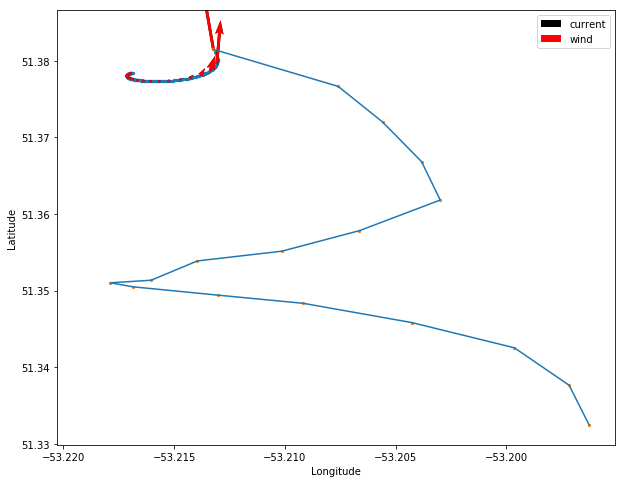

In [44]:
plot.plot_iceberg_track(xds['latitude'], xds['longitude'], 
                        vectors=[
                                 [xds['current_eastward_force'], xds['current_northward_force']],
                                 [xds['wind_eastward_force'], xds['wind_northward_force']]
                                ], 
                        arrow_colors=['black', 'red'], arrow_labels=['current', 'wind'],
                        ref_track=(ref_lats, ref_lons))